In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
# import pyflux as pf
from datetime import datetime
from datetime import timedelta
from missing_imputation import DataImputer
from frequency_estimator import FrequencyEstimator
from seasonality_trend import SeasonalityDetector
from forecasting import Forecast
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 50
pd.options.display.max_rows = 500

In [3]:
# Basepack-Cluster level data from 11th Jan'2015 to 20th May'2018 as ten day period demand
# total of 121 ten-day-period sales data at basepack-cluster level as to showcase the working of this pipeline
# one can increase/ decrease the frequency of data and make it daily, weekly, bi-weekly, monthly data etc.  
# total of 108 products and across 14 cluster of regions across India
# making it total of 695 usique basepack-cluster or item-store combinations
bpc_df = pd.read_csv('Filtered_BP_Clusters.csv')
# bpc_df = pd.read_csv('top_bp_clus.csv').dropna()
bpc_df.head()

,Basepack,BP Desc,Cluster,BP_CLUS,Contribution (in %),201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201513,201514,201515,201516,201517,201518,201519,201520,201521,...,201727,201728,201729,201730,201731,201732,201733,201734,201735,201736,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201813,201814,Sales in last 6 Months (in KGs)
0,70354,70354 : TAAZA LEAF POLY 250G,UTTAR PRADESH,70354 UTTAR PRADESH,7.246401,79882.0,124242.0,38498.0,59005.0,207567.0,59829.0,55093.0,138035.0,45195.0,43672.0,81992.0,46918.0,67438.0,73421.0,55350.0,74244.0,113302.0,45787.0,45662.0,102646.0,...,184099.75,115839.75,132473.00,193314.50,115176.00,138151.25,162575.00,171803.00,233452.75,157358.25,113642.50,214248.50,224264.36,176041.00,162056.79,200458.50,120628.75,138219.25,202498.50,116201.25,106691.61,211922.5,111691.75,138421.75,2962176.01
1,80377,80377 : TAAZA LEAF 100G,UTTAR PRADESH,80377 UTTAR PRADESH,5.106783,2673.0,15408.0,10399.0,18796.0,492.0,3144.0,10174.0,19127.0,15685.0,4937.0,15624.0,14376.0,24926.0,26304.0,20789.0,16482.0,22421.0,16823.0,12074.0,16632.0,...,100748.70,72891.20,83293.50,104552.90,95801.00,115921.40,137471.60,94553.70,107900.80,142900.20,89796.00,130313.10,134373.80,119909.50,167610.40,148327.90,104782.40,91768.80,157482.60,86426.50,66770.50,118727.6,88169.70,100260.30,2087545.40
2,70350,70350 : TAAZA LEAF RS.10,UTTAR PRADESH,70350 UTTAR PRADESH,2.864954,45098.0,67774.0,38344.0,39183.0,55239.0,25579.0,32986.0,54725.0,24278.0,25584.0,38267.0,28140.0,29214.0,42151.0,23897.0,29640.0,42868.0,26282.0,36819.0,51709.0,...,108946.88,38787.90,44998.64,57506.35,52432.02,58927.01,67502.04,68481.28,60737.11,75867.02,52000.10,98594.97,82698.21,91792.74,64495.17,72006.39,50755.17,52930.22,72803.11,51256.86,47911.02,76233.6,36864.00,48203.81,1171132.82
3,80647,80647 : TZA LF NW BLND 250G PNJBHRYNACHTTSGHMP,PUNJAB-HARYANA-HILLS,80647 PUNJAB-HARYANA-HILLS,2.640193,0.0,0.0,0.0,2352.0,40254.0,11814.0,13640.0,31724.0,14916.0,19908.0,25035.0,14539.0,14474.0,25740.0,12518.0,16169.0,23540.0,21141.0,12931.0,22682.0,...,62858.00,44770.00,58056.00,57407.00,35370.00,47111.50,59896.00,36421.00,50150.75,74095.50,46220.75,67481.00,93666.00,58557.50,61249.25,75535.25,34360.00,59698.25,76728.50,38343.25,55134.25,96202.5,42702.00,52813.50,1079255.25
4,70199,70199 : 3 ROSES DUST CARTON 100G,TAMIL NADU,70199 TAMIL NADU,2.220647,43319.0,67825.0,54107.0,38386.0,63641.0,34447.0,41789.0,67951.0,52022.0,34047.0,61673.0,31697.0,32074.0,76496.0,55857.0,43859.0,62390.0,49134.0,42603.0,64320.0,...,62769.80,58088.70,42475.90,52332.60,52743.80,56799.40,50153.10,51815.40,44965.20,56813.00,49347.20,65875.50,48890.40,61062.80,41995.70,53903.00,35223.90,50333.40,57443.50,45951.70,41231.10,66064.7,41360.30,45323.90,907753.80


In [4]:
bpc_df.describe()

,Basepack,Contribution (in %),201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201513,201514,201515,201516,201517,201518,201519,201520,201521,201522,201523,201524,...,201727,201728,201729,201730,201731,201732,201733,201734,201735,201736,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201813,201814,Sales in last 6 Months (in KGs)
count,695.000000,695.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,...,651.000000,652.000000,657.000000,648.000000,654.000000,655.000000,656.000000,660.000000,669.000000,669.000000,678.000000,673.000000,673.000000,674.000000,672.000000,672.000000,673.000000,666.000000,674.000000,674.00000,679.000000,672.000000,660.000000,682.000000,6.950000e+02
mean,75004.328058,0.128889,2078.750385,2849.289676,2225.938367,2053.554700,2960.975347,1514.015408,1721.394453,3215.201849,1917.084746,1579.312789,2391.118644,1832.821263,1789.620955,2966.845917,1887.123267,1750.081664,2830.003082,1939.702619,1789.251156,2603.590139,2653.009245,1604.875193,2610.497689,...,3759.281045,2760.581135,2531.094414,3394.267315,2752.763792,3139.862412,3366.070366,2985.086455,2874.985934,3615.039910,2708.624587,3634.118782,3730.942318,3373.720134,3053.298214,3431.835744,2174.997013,2738.441246,3567.346721,2495.31546,2324.015052,3628.567188,2238.213394,2646.489809,5.268705e+04
std,5082.769255,0.442734,5989.864095,8786.277722,6073.863569,5559.096193,10684.398943,4434.099086,4770.094226,9271.935529,5174.819458,4151.665156,6661.835402,4919.138906,5000.910796,7941.246669,5133.254371,5129.283482,8030.272362,5062.676402,4725.270970,7806.371919,8256.192470,4099.570258,6933.943586,...,11980.775058,8106.030376,8311.182069,11095.737488,8424.574269,9737.358360,10912.811362,9914.142572,11563.318359,11541.383824,8136.289703,12677.690683,13233.020150,11387.164388,11133.183825,12316.012089,7718.803384,8894.849643,12784.723296,7856.57095,7199.288498,12521.241153,7412.887676,8948.883649,1.809805e+05
min,60695.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,6.000000e-01
25%,70350.000000,0.000682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,5.000000,9.000000,6.000000,6.000000,...,23.845000,15.780000,14.820000,18.930000,19.345000,19.670000,20.265000,17.810000,12.510000,14.240000,15.035000,17.460000,16.050000,16.457500,16.882500,14.597500,11.340000,12.262500,14.902500,15.83500,12.000000,20.125000,12.432500,7.065000,2.789700e+02
50%,70915.000000,0.004946,44.000000,38.000000,48.000000,40.000000,60.000000,45.000000,38.000000,76.000000,66.000000,67.000000,88.000000,67.000000,48.000000,82.000000,71.000000,56.000000,84.000000,68.000000,64.000000,90.000000,112.000000,94.000000,118.000000,...,173.440000,132.000000,115.200000,152.050000,140.090000,143.950000,152.805000,142.225000,119.600000,132.000000,120.275000,149.520000,119.000000,128.560000,137.875000,123.590000,89.500000,123.710000,116.230000,110.02000,113.600000,127.525000,107.800000,94.020000,2.021870e+03
75%,80586.000000,0.071281,1157.000000,1382.000000,1235.000000,1281.000000,1589.000000,801.000000,1161.000000,1865.000000,1032.000000,1016.000000,1413.000000,1065.000000,987.000000,1750.000000,1205.000000,1126.000000,1646.000000,1210.000000,1120.000000,1404.000000,1443.000000,1211.000000,1754.000000,...,2144.260000,1756.437500,16

In [5]:
len(list(bpc_df['Basepack'].unique())), len(list(bpc_df['Cluster'].unique()))

(108, 14)

In [6]:
100*bpc_df['Sales in last 6 Months (in KGs)'][0]/bpc_df['Sales in last 6 Months (in KGs)'].sum()

8.089509822235003

In [7]:
df = bpc_df.copy()
del df['Basepack']
del df['Cluster']
del df['Contribution (in %)']
del df['BP Desc']
del df['Sales in last 6 Months (in KGs)']
df = df.transpose()
df.columns = df.iloc[0]
# print(df.columns)

# df = df.drop(df.index[[0,-4,-3,-2,-1]])
df.reset_index(inplace = True)
df.drop([0], axis=0, inplace=True)
df.head()

BP_CLUS,index,70354 UTTAR PRADESH,80377 UTTAR PRADESH,70350 UTTAR PRADESH,80647 PUNJAB-HARYANA-HILLS,70199 TAMIL NADU,80647 MP-CHG-RJ,70361 UTTAR PRADESH,70200 TAMIL NADU,80377 PUNJAB-HARYANA-HILLS,70283 MP-CHG-RJ,80377 MP-CHG-RJ,70293 KARNATAKA-KERALA,70197 TAMIL NADU,70294 KARNATAKA-KERALA,70283 PUNJAB-HARYANA-HILLS,70293 ANDHRA PRADESH,70219 TAMIL NADU,80377 BIHAR,70293 GREATER MAHARASHTRA,70298 ORISSA-JHARKHAND,70369 ANDHRA PRADESH,70294 GREATER MAHARASHTRA,70367 ANDHRA PRADESH,70200 ANDHRA PRADESH,...,80446 UTTAR PRADESH,80667 ORISSA-JHARKHAND,80667 PUNJAB-HARYANA-HILLS,80427 NESA,80406 NESA,80427 MP-CHG-RJ,80427 UTTAR PRADESH,80407 MP-CHG-RJ,80406 UTTAR PRADESH,80407 DELHI-GREATER DELHI,80446 GUJARAT,80427 GREATER MAHARASHTRA,80407 UTTAR PRADESH,80635 MP-CHG-RJ,80446 ORISSA-JHARKHAND,80406 MP-CHG-RJ,80407 MUMBAI-PUNE,80406 GUJARAT,80446 BIHAR,80407 WEST BENGAL,80679 TAMIL NADU,80407 GREATER MAHARASHTRA,80407 GUJARAT,80427 GUJARAT,80427 WEST BENGAL
1,201502,79882.0,2673.0,45098.0,0.0,43319.0,0.0,39340.0,30108.0,1127.0,27205.0,1079.0,19490.0,22186.0,25314.0,18473.0,12761.0,15139.0,2423.0,7816.0,12540.0,32650.0,15226.0,24903.0,25677.0,...,7.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,7.0,NaN,1.0,0.0,0.0,0.0
2,201503,124242.0,15408.0,67774.0,0.0,67825.0,0.0,61834.0,40289.0,2952.0,54068.0,1151.0,22811.0,29541.0,36537.0,30871.0,14820.0,17294.0,1894.0,9874.0,14052.0,29820.0,25113.0,23183.0,21812.0,...,2.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0
3,201504,38498.0,10399.0,38344.0,0.0,54107.0,0.0,50185.0,35361.0,3842.0,51011.0,1367.0,18287.0,30482.0,30957.0,27397.0,10957.0,17977.0,2768.0,8895.0,21042.0,29519.0,18811.0,21119.0,22606.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,4.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,0.0
4,201505,59005.0,18796.0,39183.0,2352.0,38386.0,1650.0,50761.0,33831.0,4128.0,33837.0,445.0,15983.0,21908.0,24015.0,25089.0,12908.0,14351.0,2455.0,9923.0,20889.0,22321.0,19114.0,19689.0,20618.0,...,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,4.0,NaN,1.0,0.0,0.0,0.0
5,201506,207567.0,492.0,55239.0,40254.0,63641.0,16522.0,55469.0,50418.0,1738.0,46242.0,797.0,22194.0,41787.0,33230.0,31538.0,15095.0,21774.0,2799.0,10872.0,19816.0,29890.0,23545.0,24047.0,29233.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [8]:
df['index'] = pd.to_numeric(df['index'])
df['year'] = (df['index']/100).astype(int)
df['month'] = (((df['index']%100)/3)-0.1+1).astype(int)
df['day'] = (((df['index']%100)-1)%3*10+1) 

df['index'] = df.apply(lambda row: datetime(row['year'], row['month'], row['day']), axis=1)
df['index'] = pd.to_datetime(df['index'])
del df['year'], df['month'], df['day'] 
df['index'] = df['index']-timedelta(days=10)
df.index = df['index']
del df['index']
df = df[:-4]
df.sample(20)

BP_CLUS,70354 UTTAR PRADESH,80377 UTTAR PRADESH,70350 UTTAR PRADESH,80647 PUNJAB-HARYANA-HILLS,70199 TAMIL NADU,80647 MP-CHG-RJ,70361 UTTAR PRADESH,70200 TAMIL NADU,80377 PUNJAB-HARYANA-HILLS,70283 MP-CHG-RJ,80377 MP-CHG-RJ,70293 KARNATAKA-KERALA,70197 TAMIL NADU,70294 KARNATAKA-KERALA,70283 PUNJAB-HARYANA-HILLS,70293 ANDHRA PRADESH,70219 TAMIL NADU,80377 BIHAR,70293 GREATER MAHARASHTRA,70298 ORISSA-JHARKHAND,70369 ANDHRA PRADESH,70294 GREATER MAHARASHTRA,70367 ANDHRA PRADESH,70200 ANDHRA PRADESH,80377 ORISSA-JHARKHAND,...,80446 UTTAR PRADESH,80667 ORISSA-JHARKHAND,80667 PUNJAB-HARYANA-HILLS,80427 NESA,80406 NESA,80427 MP-CHG-RJ,80427 UTTAR PRADESH,80407 MP-CHG-RJ,80406 UTTAR PRADESH,80407 DELHI-GREATER DELHI,80446 GUJARAT,80427 GREATER MAHARASHTRA,80407 UTTAR PRADESH,80635 MP-CHG-RJ,80446 ORISSA-JHARKHAND,80406 MP-CHG-RJ,80407 MUMBAI-PUNE,80406 GUJARAT,80446 BIHAR,80407 WEST BENGAL,80679 TAMIL NADU,80407 GREATER MAHARASHTRA,80407 GUJARAT,80427 GUJARAT,80427 WEST BENGAL
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-02-01,117708.05,30506.4,44211.64,31330.75,40618.3,21600.75,36692.26,34017.25,8417.5,37884.0,4223.9,14747.5,34227.35,28305.75,21887.51,13931.3,16138.31,2819.7,8256.8,15073.0,21995.5,21605.0,17879.1,17780.5,7648.1,...,3.24,NaN,NaN,NaN,0.0,0.0,1.8,0.6,2.55,NaN,0.0,3.0,1.55,21.45,0.0,0.65,0.0,NaN,NaN,1.1,NaN,0.6,0.6,NaN,0.4
2015-11-01,87455.0,22148.0,39240.0,20019.0,45863.0,9326.0,43920.0,31025.0,4530.0,28401.0,1319.0,14034.0,14098.0,23911.0,22520.0,11224.0,17064.0,2514.0,8225.0,15504.0,26161.0,20295.0,17288.0,17804.0,8758.0,...,2.0,14.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0,0.0,0.0,1.0
2017-07-11,146816.25,65328.0,43560.0,51190.0,57341.5,37248.0,28947.21,41614.0,30696.0,28620.0,24384.0,38172.0,35933.8,28068.0,29937.5,22620.0,25132.0,16392.0,25595.5,24503.5,23266.75,18670.25,17808.0,19620.0,17496.0,...,1.92,NaN,1693.44,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.16,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-22,116201.25,86426.5,51256.86,38343.25,45951.7,39585.75,27648.06,33551.0,20706.5,19221.69,31128.4,34051.8,26757.25,27065.25,17739.25,23399.0,24925.19,22246.2,24478.8,16250.84,22487.0,14733.25,21584.2,20293.75,10844.2,...,0.0,0.0,0.0,3.0,NaN,0.0,NaN,1.2,NaN,0.0,0.0,0.0,NaN,0.0,0.72,NaN,0.0,NaN,0.0,0.0,0.72,0.0,NaN,0.0,0.0
2016-05-22,89600.72,17571.2,30937.18,24837.5,53520.1,18781.0,26594.4,34089.01,5375.9,21563.74,2096.1,17789.1,34396.65,29736.78,20684.5,8415.4,17614.29,1978.8,4461.1,12877.0,23221.53,10609.75,22343.6,18345.52,6735.7,...,2.28,NaN,0.0,NaN,NaN,0.0,0.0,1.2,0.0,NaN,NaN,0.0,1.1,14.63,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0
2017-09-11,184099.75,100748.7,108946.88,62858.0,62769.8,57116.75,45872.94,49650.0,25529.4,55979.25,32964.9,40754.4,37250.95,35301.0,37625.0,29273.0,32274.43,11015.8,30587.8,30018.75,26775.25,26685.75,22023.1,23684.76,14469.0,...,1.44,7.85,16.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,8.22,0.0,NaN,0.45,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
2017-12-01,233452.75,107900.8,60737.11,50150.75,44965.2,38703.0,41519.5,32695.76,39762.5,24872.75,28437.9,26696.4,24991.2,24541.0,23803.5,23841.4,22337.44,16798.2,16872.8,17469.98,22891.75,15554.0,16231.3,18846.75,13773.3,...,0.0,0.9,0.0,NaN,1.2,NaN,0.0,0.55,0.0,2.8,NaN,0.6,NaN,0.0,0.0,NaN,0.0,0.6,NaN,0.0,NaN,0.0,0.6,NaN,NaN
2017-04-21,87362.76,63825.0,30141.29,36058.5,36289.0,26168.0,22169.1,24085.75,20880.6,39298.41,13466.1,21439.8,20630.5,24603.75,20512.36,10073.3,18616.11,10125.0,14614.6,19995.5,18668.75,16651.25,16458.9,13766.5,8433.0,...,1.6,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,51.16,0.0,0.0,0.6,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2017-08-22,89790.75,91990.7,69350.0,40703.75,53530.8,44133.0,30269.04,39394.75,29531.7,35412.0,28809.6,33192.0,31751.75,34620.0,28252.5,26340.0,20031.96,21072.0,21899.5,24476.5,25486.75,20686.5,21995.4,22378.75,14243.2,...,4.8,1.01,1676.89,NaN,NaN,NaN,0.6,NaN,1.2,NaN,0.0,NaN,NaN,3.9,0.48,NaN,0.0,0.0,NaN,NaN,0.23,NaN,NaN,NaN,NaN


In [9]:
df.describe(include='all')

BP_CLUS,70354 UTTAR PRADESH,80377 UTTAR PRADESH,70350 UTTAR PRADESH,80647 PUNJAB-HARYANA-HILLS,70199 TAMIL NADU,80647 MP-CHG-RJ,70361 UTTAR PRADESH,70200 TAMIL NADU,80377 PUNJAB-HARYANA-HILLS,70283 MP-CHG-RJ,80377 MP-CHG-RJ,70293 KARNATAKA-KERALA,70197 TAMIL NADU,70294 KARNATAKA-KERALA,70283 PUNJAB-HARYANA-HILLS,70293 ANDHRA PRADESH,70219 TAMIL NADU,80377 BIHAR,70293 GREATER MAHARASHTRA,70298 ORISSA-JHARKHAND,70369 ANDHRA PRADESH,70294 GREATER MAHARASHTRA,70367 ANDHRA PRADESH,70200 ANDHRA PRADESH,80377 ORISSA-JHARKHAND,...,80446 UTTAR PRADESH,80667 ORISSA-JHARKHAND,80667 PUNJAB-HARYANA-HILLS,80427 NESA,80406 NESA,80427 MP-CHG-RJ,80427 UTTAR PRADESH,80407 MP-CHG-RJ,80406 UTTAR PRADESH,80407 DELHI-GREATER DELHI,80446 GUJARAT,80427 GREATER MAHARASHTRA,80407 UTTAR PRADESH,80635 MP-CHG-RJ,80446 ORISSA-JHARKHAND,80406 MP-CHG-RJ,80407 MUMBAI-PUNE,80406 GUJARAT,80446 BIHAR,80407 WEST BENGAL,80679 TAMIL NADU,80407 GREATER MAHARASHTRA,80407 GUJARAT,80427 GUJARAT,80427 WEST BENGAL
count,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,117.0,...,117.0,69.0,91.0,56.0,46.0,93.0,71.0,101.0,86.0,68.0,82.0,96.0,99.0,117.0,117.0,90.0,116.0,70.0,42.0,89.0,28.0,94.0,70.0,74.0,92.0
unique,117.0,117.0,117.0,115.0,117.0,115.0,117.0,117.0,117.0,117.0,116.0,117.0,117.0,117.0,117.0,117.0,117.0,115.0,116.0,117.0,117.0,117.0,117.0,116.0,117.0,...,45.0,30.0,42.0,5.0,4.0,11.0,7.0,24.0,8.0,8.0,9.0,12.0,11.0,57.0,19.0,12.0,22.0,5.0,4.0,17.0,15.0,12.0,5.0,5.0,12.0
top,79882.0,2673.0,45098.0,0.0,43319.0,0.0,39340.0,30108.0,1127.0,27205.0,1680.0,19490.0,22186.0,25314.0,18473.0,12761.0,15139.0,1750.0,8225.0,12540.0,32650.0,15226.0,24903.0,17566.0,879.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
freq,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,...,16.0,34.0,50.0,43.0,36.0,68.0,57.0,48.0,69.0,61.0,59.0,69.0,73.0,50.0,58.0,64.0,53.0,63.0,38.0,55.0,12.0,63.0,58.0,58.0,69.0


# Code Flow

Loop over all the basepack-cluster based time-series

## Data Cleaning or Pre-processing
* Decide the split for train/ test/ validation data
* Fill NaN's using pad method from pandas library
* Remove outliers using Forecast module
* Fill the missing values using DataImputer module, using meanImpute as of now
* Create the data for models: original, trend-removed, seasonality-removed or both-removed (i.e. close to white noise)

## Estimating Periodicity
* Estimate periodicity of the sale data or the timeseries under study

## Time-series Visualizer
* Plot the timesere data. x-axis: sale data, y-axis: ten-day periods (as date)
* Plot the trend and seasonality components of the series using the computed periodicity

## Modelling the timeseries and parameter tuning
* Perform parameter tuning for the each models i.e. select AR lags, MA lags and #times differencing
* These parameters are selected using the library called hyperopt using optimized grid search approach say tpe
* Best parameters are selected based on the mimimum Akaike information criterion (AIC) across version of same model

> The Akaike information criterion (AIC) is a method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data. 


## Post-Processing, Computing Evaluation Metrics
* Once you have computed the all the models for each basepack-cluster using the best hyperparameters we select the best model amongst various variants of traditional timeseries models
* Select a metric from the measures.py module. Select what operations need to be performed in regards to that metric i.e manimize it or minimize it
* Do the prediction using on the validation dataset, Compute the evaluation metrics and select the model with the best metric.
* To perform evaluation you first do undifferencing, then you add back the trend or seasonality components whereever it was removed. Now using the post-processed data you compute the evaluation metric.

## Best Model selection and Prediction on test data
* Once you decide for each basepack-cluster which parameters works the best and then which model gives out the best predictions one can use the best model and its parameters/ hyperparameters to make the prediction on the test data
* Company XXXX gave us a evaluation metric called Integral Normalized Absolute Mean Error (IMAME) that clubs all the errors in prediction at basepack cluster level and gives out a single score to access the accuracy or effectiveness of our predictions.


You are here detecting outliers from the dataset
%f period_02 4.0
%f period_03 3.0
Periodicity is:  4.0
You are in seasonal_trend module calculating all components of timeseries


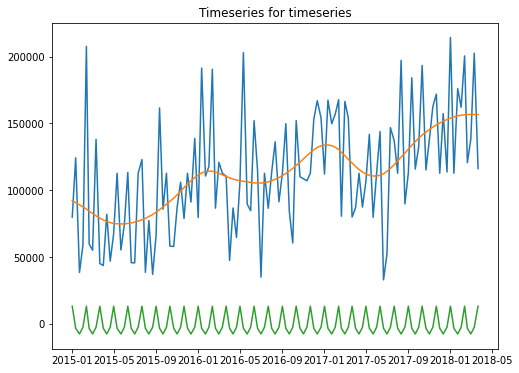

You are here in forecasting module preparing datasets for different models
You are in seasonal_trend module calculating all components of timeseries
You are in forecasting module functionality parameter tuning part
  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

job exception: 'DataFrame' object has no attribute 'ix'



  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]


AttributeError: 'DataFrame' object has no attribute 'ix'

In [13]:
bucket = pd.DataFrame()
df = df.iloc[:, :200]
ERR_overall_den, ERR_overall_den_1, ERR_overall_den_2 = 0, 0, 0
ERR_overall_num, ERR_overall_num_1, ERR_overall_num_2 = 0, 0, 0
for i in range(df.shape[1]):
    # try:
    # Columns to timeseries
    column_name = df.columns[i]
    df.rename(columns={column_name: "timeseries"}, inplace=True)
    temp = pd.DataFrame(df.iloc[:,i])
    temp = temp.fillna(method='pad')

    # Forecasting individual columns and initialization of parameters
    factor = 0.83 # train/ val data split
    evals = 5 # evaluate on 5 data points
    ensemble_metric = 'unlr'
    steps = len(df) - int(factor*len(df))
    pipeline = Forecast(temp, factor, steps, evals, ensemble_metric)

    # Outlier Detection and Missing value Imputation
    pipeline.outlier()
    preprocessor = DataImputer(pipeline.timeseries)
    preprocessor.meanInpute()

    # Plotting and storing timeseries
    pipeline.timeseries = preprocessor.timeseries
    pipeline.timeseries.index = df.index
    df[:][str(i)] = pipeline.timeseries
    plt.subplot()
    plt.plot(pipeline.timeseries)
    plt.title('Timeseries for '+str(column_name))

    # Peridicity calculation
    freq_estimator = pipeline.timeseries)
    periodicity = freq_estimator.periodicity_estimator()

    # Decomposition and Hyperparameter tuning
    seasonality_detector = SeasonalityDetector(pipeline.timeseries, periodicity)
    seasonality_detector.trend_seasonal_comp()
    seasonality_detector.plot_trend_seasonal_comp('hp', 'add_decomp')
    pipeline.dataset('hp', 'add_decomp', periodicity)
    pipeline.parameter_tuning(periodicity)
    
    # Model tuning and selection
    model, name, ERR, ERR_1, ERR_2, ensembled_pred_df = pipeline.select_model(periodicity)
    ensembled_pred_df.to_csv('Time_Series_Analysis.csv', header = [column_name])
    
    if ( str(name) not in ['wma', 'naive', 'drift', 'Linear_Holt_Winter', 'Additive_Holt_Winter', 'Multiplicative_Holt_Winter']):
        bucket[column_name] = model.predict( h = int( (1-factor)*len(df) + 5) )[-steps:]
    else:
        bucket[column_name] = name
        
    df.rename(columns={"timeseries" : column_name}, inplace=True)
    print("bucket", column_name, "\n", bucket[column_name])

    # Overall Accuracy using Company XXXX's metric
    ERR_overall_den = ERR_overall_den + np.sum(np.array(temp).flatten())
    ERR_overall_num = ERR_overall_num + (1-ERR)*np.sum(np.array(temp).flatten())
    ERR_overall = 1 - (ERR_overall_num/ERR_overall_den)

    ERR_overall_den_1 = ERR_overall_den_1 + np.sum(np.array(temp).flatten())
    ERR_overall_num_1 = ERR_overall_num_1 + (1-ERR_1)*np.sum(np.array(temp).flatten())
    ERR_overall_1 = 1 - (ERR_overall_num_1/ERR_overall_den_1)

    ERR_overall_den_2 = ERR_overall_den_2 + np.sum(np.array(temp).flatten())
    ERR_overall_num_2 = ERR_overall_num_2 + (1-ERR_2)*np.sum(np.array(temp).flatten())
    ERR_overall_2 = 1 - (ERR_overall_num_2/ERR_overall_den_2)
    # except Exception as e:
    #     print("Forecasting crashed because of the error {}".format(e))
    break
    
print('Final Cluster Level accuracy_measure : ' + str(ERR_overall))
print('Final Cluster Level accuracy_measure tdp_(t+5:t+7): ' + str(ERR_overall_1))
print('Final accuracy_measure tdp_(t+8:t+10): ' + str(ERR_overall_2))

bucket = pd.DataFrame(bucket)
print("bucket", bucket)
bucket.to_csv('prediction_results')